1) USE Saved ConvNet for Distinguish Normal & Covid19 ChestXray Dataset...

In [4]:
# import libraries in usage

import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
from collections import OrderedDict
import numpy as np
import nibabel as nib
from torch.utils.data import DataLoader , TensorDataset, SubsetRandomSampler, random_split

In [2]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on " + str(device) + ".")
else:
    device = torch.device("cpu")
    print("running on" + str(device) + ".")
# torch.cuda.device_count()


running on cuda:0.


In [3]:
#import ready model

import convNet

In [ ]:
# load pre-saved model
"""
opt = optim.Adam(cnn.parameters(), lr=0.001)

checkpoint = torch.load('D:/projects/Neural_Networks/coursera_v3/coursera/model/model')
cnn.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])"""

In [ ]:
"""print(checkpoint['model_state_dict'])"""

In [5]:
#preparing dataset as done in Cats & Dogs Classifying

REBUILD_DATA =False # set to true to one once, then back to false unless you want to change something in your


class prepare_data():
    INFCTD = 'D:\\projects\\Neural_Networks\\research\\datasets\\576013_1042828_bundle_archive\\COVID-19 Radiography Database\\COVID-19'
    NORMAL = 'D:\\projects\\Neural_Networks\\research\\datasets\\576013_1042828_bundle_archive\\COVID-19 Radiography Database\\NORMAL'
    LABELS = {INFCTD: 1, NORMAL: 0}
    
    infctdcount= 0
    normalcount= 0
    
    IMG_SIZE = 64 # if needed due to memory limit, change image size. if not, put the original image size.

    data = []
    
    def make_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" or "jpeg" or "png" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #for now let's make it gray scale
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.data.append([np.array(img), np.eye(2)[
                            self.LABELS[label]]])  # makes one_hot vector
                        
                        if label == self.INFCTD:
                            self.infctdcount += 1
                        elif label == self.NORMAL:
                            self.normalcount += 1
                        else:
                            print("fck off")
                    except Exception as e:
                        print(label, f, str(e))
                        pass
                        
        np.random.shuffle(self.data) # shuffling gets better result.
        np.save("D:\\projects\\Neural_Networks\\coursera_v3\\coursera\\data\\data_two_label", self.data)




In [6]:
# run above

if REBUILD_DATA:
    prep =prepare_data()
    prep.make_data()
    print('INFECTED PATIENTS:', prep.infctdcount)
    print('HEALTHY PATIENTS', prep.normalcount)

In [7]:
data = np.load("D:\\projects\\Neural_Networks\\coursera_v3\\coursera\\data\\data_two_label.npy", allow_pickle=True)
print(len(data))   

1560


In [8]:
X = torch.Tensor([i[0] for i in data]) # create tensor for images

In [9]:
X = X / 255 # scale them to be between 0 and 1

In [10]:
X.shape

torch.Size([1560, 64, 64])

In [11]:
y = torch.Tensor([i[1] for i in data]) #observations / real labels / hot_vectors we created above

In [12]:
y

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]])

In [13]:
y.shape

torch.Size([1560, 2])

In [14]:
# now let's create datasets:

dataset = TensorDataset(X , y)

valid_set = torch.utils.data.Subset(dataset, (1,200))

In [15]:
>>> a = random_split(range(10), [3, 7])

In [16]:
print(random_split(range(10), [3, 7]))

[<torch.utils.data.dataset.Subset object at 0x000002721256E898>, <torch.utils.data.dataset.Subset object at 0x000002721256E5C0>]


In [17]:
print(a[1][5])

4


In [18]:
print(random_split(dataset, [100, 300, 1160]))

[<torch.utils.data.dataset.Subset object at 0x000002721256ECC0>, <torch.utils.data.dataset.Subset object at 0x000002721256E710>, <torch.utils.data.dataset.Subset object at 0x000002721256E748>]


In [19]:
test_dt, valid_dt, train_dt = random_split(dataset, [100, 300, 1160]) # always choose random :).

In [20]:
sampler = SubsetRandomSampler(list(range(1160)))  # for now, let's just load only training data set.

In [21]:
BATCH_SIZE = 75

In [22]:
# let's create torch data loaders.

train = DataLoader(train_dt , batch_size = BATCH_SIZE, sampler= sampler)

valid = DataLoader(valid_dt , batch_size = BATCH_SIZE)

test = DataLoader(valid_dt , batch_size = 100) # we want them only for test, that's why one batch.

In [23]:
#neural network with dropout

class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        # self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
        # self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(64,64).view(-1, 1, 64,64)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #print("5.1:", x.shape)
        self.fc2 = nn.Linear(512, 2)
        #print("5.2:", x.shape)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        #print("1:", x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        #print("2:", x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        #print("3:", x.shape)


        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            #print(x[0].shape[0] , x[0].shape[1] , x[0].shape[2])
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        #print("0:", x.shape)
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        #print("4:", x.shape)
        x = F.relu(self.bn1(self.fc1(x)))
        #print("5:", x.shape)
        x = self.fc2(x)
        #print("6:", x.shape)
        x = self.dropout(x)
        #print("7:", x.shape)
        return F.softmax(x, dim=1)

In [24]:
net = Cnn().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [25]:
def fwd_pass(X, y, net, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X.to(device))
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [26]:
#train parameters

EPOCHS = 100 # to get faster results, apply for small number once. then, INCREASE it!!!!!!!!!!!!!!!!!

n= 1160 + 200

it = int(1160/200)

print(n, " ", it)

PT = "D:\\projects\\Neural_Networks\\coursera_v3\\coursera\\model\\MODELv1.1.pt"

1360   5


In [27]:
MODEL_NAME = f"model covid19.v1.1.-{time.asctime()}"

def Train(net):
    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, n, BATCH_SIZE):   
                dt = next(iter(train))
                batch_X = dt[0].view(-1, 1, 64, 64)
                batch_y = dt[1]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y , net, train_=True)
                
                if i % it == 0:
                    val_acc, val_loss = Test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                        f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")
                    torch.save({
                        'dropout cnn model': MODEL_NAME,
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, PT)

In [28]:
def Test(size=32):
    test_dt = next(iter(valid))
    X, y = test_dt[0].view(-1, 1,64, 64).to(device), test_dt[1].to(device)
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 64,64), y, net)
    return val_acc, val_loss

In [45]:
def create_acc_loss_graph(model_name):
    contents = open("../../coursera_v3/coursera/model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

model covid19.v1.1.-Wed Jul 29 16:47:57 2020


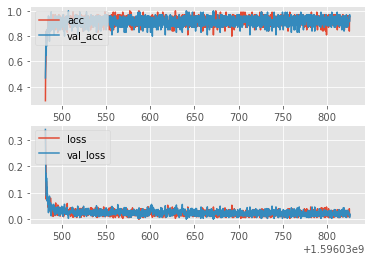

In [46]:
style.use("ggplot")
print(MODEL_NAME)

Train(net)
create_acc_loss_graph(MODEL_NAME)

In [ ]:
device

In [57]:
net.eval()
test_dt = next(iter(test))
X, y = test_dt[0].view(-1, 1,64, 64).to(device), test_dt[1].to(device)
val_acc, val_loss = fwd_pass(X.view(-1, 1, 64,64), y, net)
print("\n", val_acc, val_loss)


 0.99 tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward>)


In [53]:
with open("model.log", "a") as f:
    f.write(
                        f"\n {MODEL_NAME} notes: \n final acc: {val_acc}, \n final loss: {val_loss}, \n epochs: 100, \n batch size: 75,\n optimizer: Adam, \n loss function: MSELoss,\n model: model.pt, convNet with Dropout.,\n device: cuda 9.2 \n"
    )


In [ ]:
1360/75